In [17]:
import sys
import scanpy as sc 
import numpy as np

sys.path.append('/home/jupyter/data/PlastiNet_v2')

from plastinet.data.data_loader import create_data_objects
from plastinet.visualization.plots import plot_continous_obs, plot_tissue, plot_composition_dot_plot, plot_expression

In [4]:
adata = sc.read_h5ad("testing_data.h5ad") 

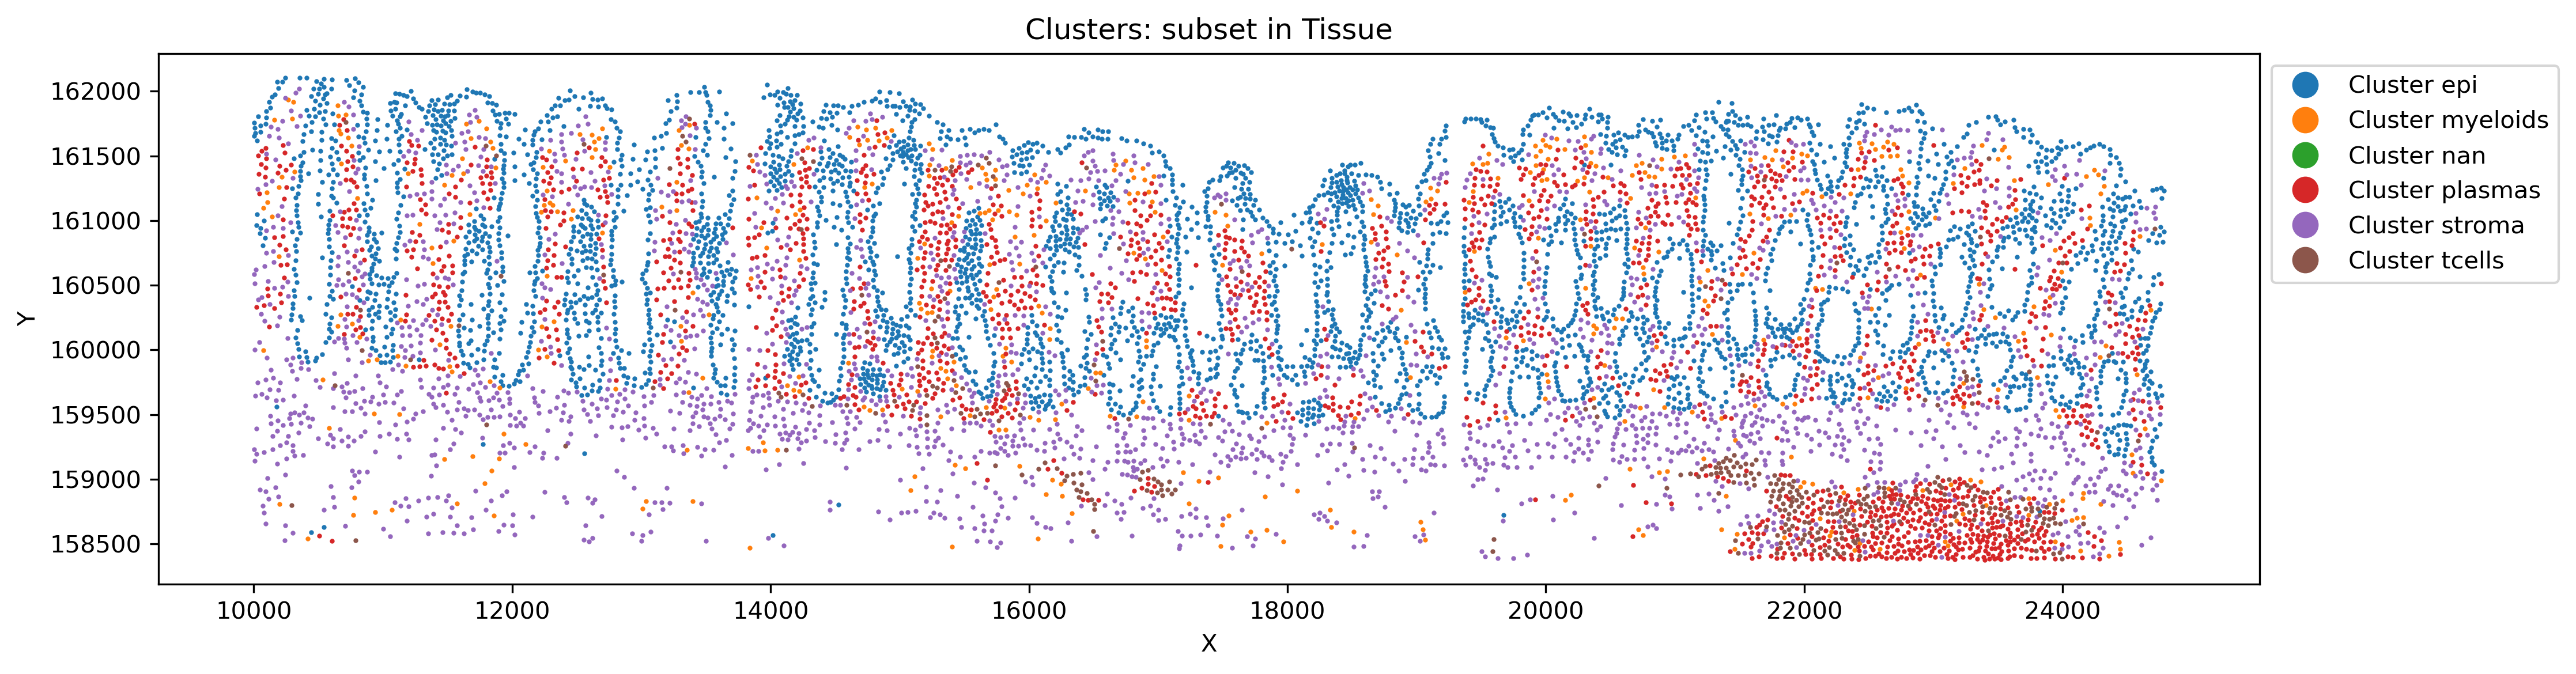

In [5]:
# plot spatialy by cell type 
plot_tissue(adata, "subset", figure_size=(15, 4))

In [6]:
# ensure spatial coordinates are in the correct place 
spatial_coords = np.array([adata.obs["X"], adata.obs["Y"]]).T
adata.obsm["spatial"] = spatial_coords

# Choose appropiate radius 

In [ ]:
import plastinet.visualization.plots as plot
# select a radius that captures neighboring cells at desired resolution

plot.plot_subsample_radius(adata, x_samples = 100, radius = 200)

# Generate Embedding

Starting GAT run...
HC_b_
Model improved and parameters saved.
Epoch [1/150] Completed. Epoch Losses: DGI Loss = 1.3921, Spatial Loss = 0.0534, L1 Loss = 0.613925, Total Loss = 2.0594
Model improved and parameters saved.
Epoch [2/150] Completed. Epoch Losses: DGI Loss = 1.3652, Spatial Loss = 0.0517, L1 Loss = 0.577182, Total Loss = 1.9940
Model improved and parameters saved.
Epoch [3/150] Completed. Epoch Losses: DGI Loss = 1.3646, Spatial Loss = 0.0513, L1 Loss = 0.541522, Total Loss = 1.9574
Model improved and parameters saved.
Epoch [4/150] Completed. Epoch Losses: DGI Loss = 1.3683, Spatial Loss = 0.0495, L1 Loss = 0.507170, Total Loss = 1.9250
Model improved and parameters saved.
Epoch [5/150] Completed. Epoch Losses: DGI Loss = 1.3655, Spatial Loss = 0.0500, L1 Loss = 0.474330, Total Loss = 1.8898
Model improved and parameters saved.
Epoch [6/150] Completed. Epoch Losses: DGI Loss = 1.3604, Spatial Loss = 0.0480, L1 Loss = 0.442723, Total Loss = 1.8511
Model improved and paramet

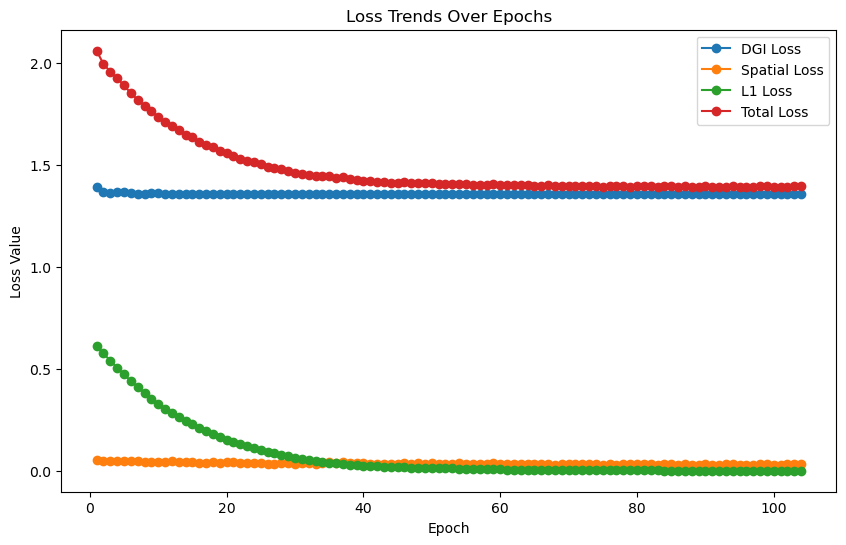


Learned alpha and beta values:
Attention Layer 1 - Alpha: 5.0000, Beta: 0.8581
Attention Layer 2 - Alpha: 5.0000, 
GAT run completed.


AnnData object with n_obs × n_vars = 9644 × 50
    obs: 'fov', 'cell_ID', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'sample_source', 'subset', 'fine_type', 'n_genes', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'X', 'Y'
    uns: 'neighbor_attention', 'reduction_layes'
    obsm: 'self_attention_weights_layer1', 'self_attention_weights_layer2'

In [7]:
import importlib
import torch
from torch_geometric.data import DataLoader

from plastinet.models import plastinet_model
from plastinet.data import data_loader, graph_utils
from plastinet.models.plastinet_model import PlastiNet
from plastinet.data.data_loader import create_data_objects
from plastinet.data.graph_utils import graph_alpha, sparse_mx_to_torch_edge_list, graph_to_sparse_matrix


plastinet = PlastiNet(
    adata=adata, # adata object
    sample_key= 'sample_source', # tissue source ID
    radius=200, # radius to consider        
    spatial_reg=0.2, # weighting of spatial term in loss function   
    z_dim=50,  # output feature size of embedding            
    lr=0.001,  # learning rate      
    beta_1=0.9, # self weighting in layer 1
    beta_2=0.1, # self weighting in layer 2
    alpha=5.0, # weight for stregth of distance decay 
    weight_decay=1e-5,  
    dropout=0.3,
    gamma=0.8, # decay in lr for each step_size incriment 
    epochs=150,
    random_seed=42,               
    patience=10,         
    mask_n = 0.7, # DGI percent of features to mask 
    spatial_percent = 0.2, # percent of cells to sample to calculate spatial loss 
    step_size = 10 
)

plastinet.run_gat()

In [8]:
embedding_adata = plastinet.embedding_adata
embedding_adata

AnnData object with n_obs × n_vars = 9644 × 50
    obs: 'fov', 'cell_ID', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'sample_source', 'subset', 'fine_type', 'n_genes', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'X', 'Y'
    uns: 'neighbor_attention', 'reduction_layes'
    obsm: 'self_attention_weights_layer1', 'self_attention_weights_layer2'

/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


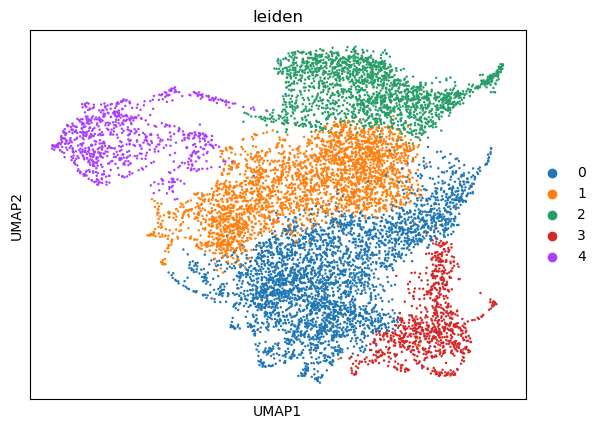

In [23]:
sc.pp.neighbors(embedding_adata, use_rep='X') 
sc.tl.umap(embedding_adata)
sc.tl.leiden(embedding_adata, resolution=0.15)
sc.pl.umap(embedding_adata, color = "leiden")

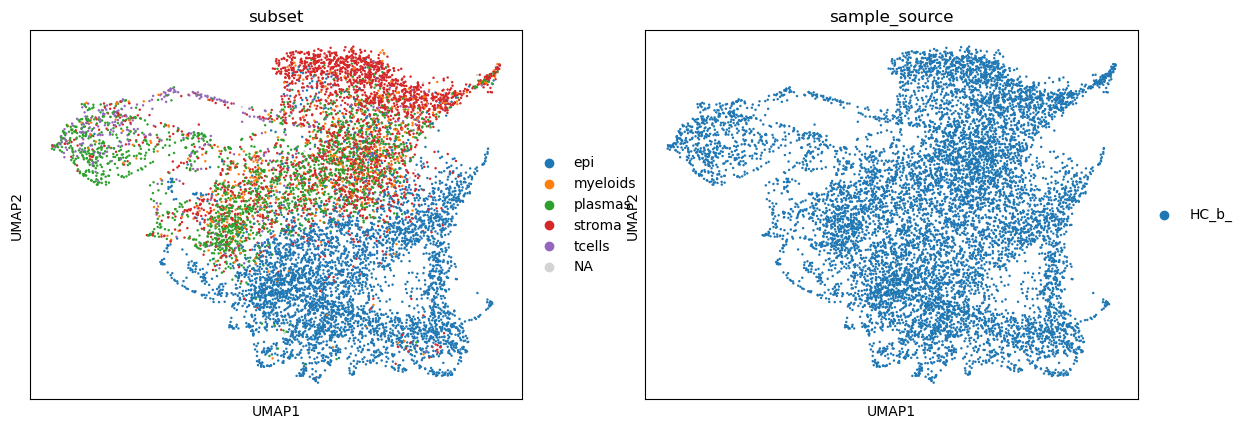

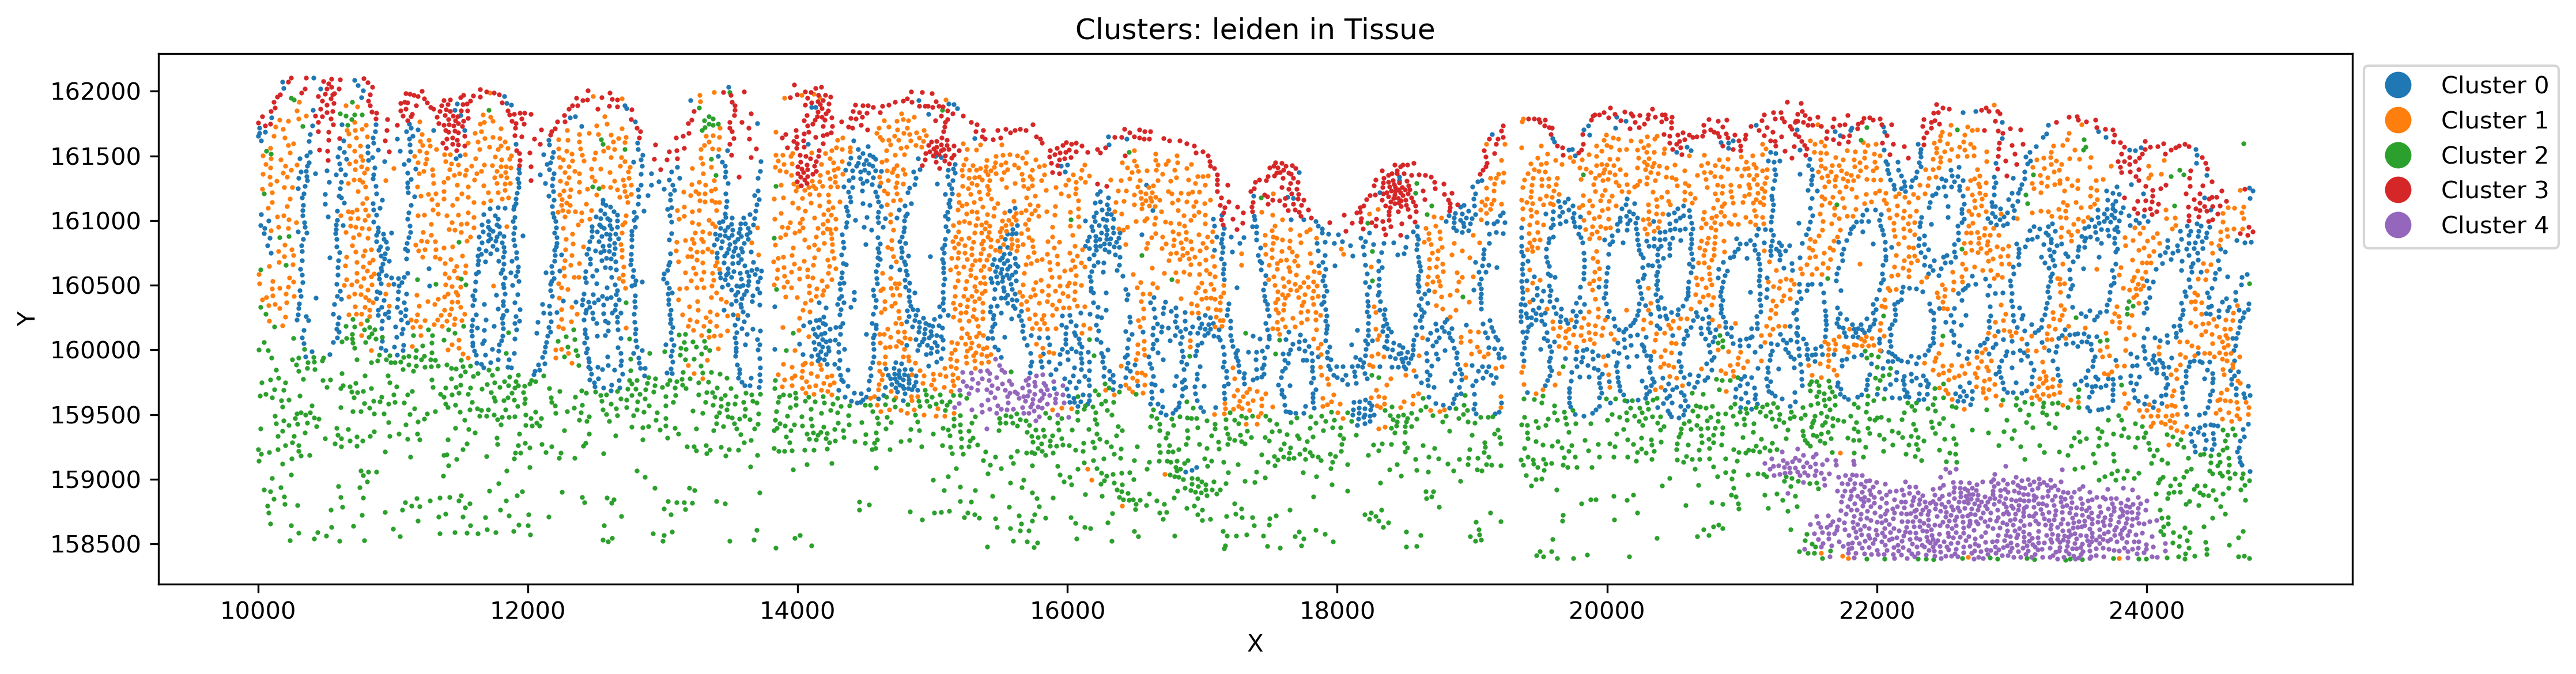

In [24]:
sc.pl.umap(embedding_adata, color = ["subset", "sample_source"])
plot_tissue(embedding_adata, "leiden", tabTen=True, figure_size=(15, 4))

/home/jupyter/mambaforge/envs/plastiNet/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/home/jupyter/data/PlastiNet_v2/plastinet/analysis/pseudotime.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gat_epi.obs["starting_score"] = exp_epi.obs["starting_score"]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


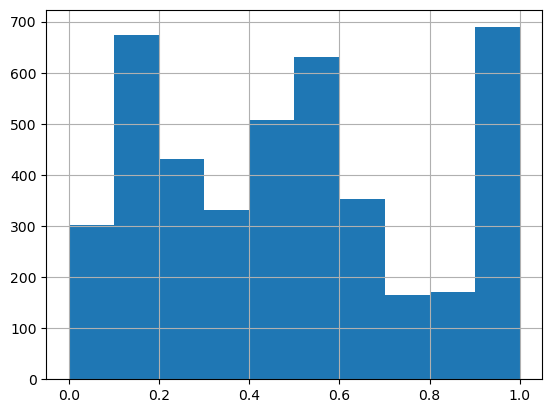

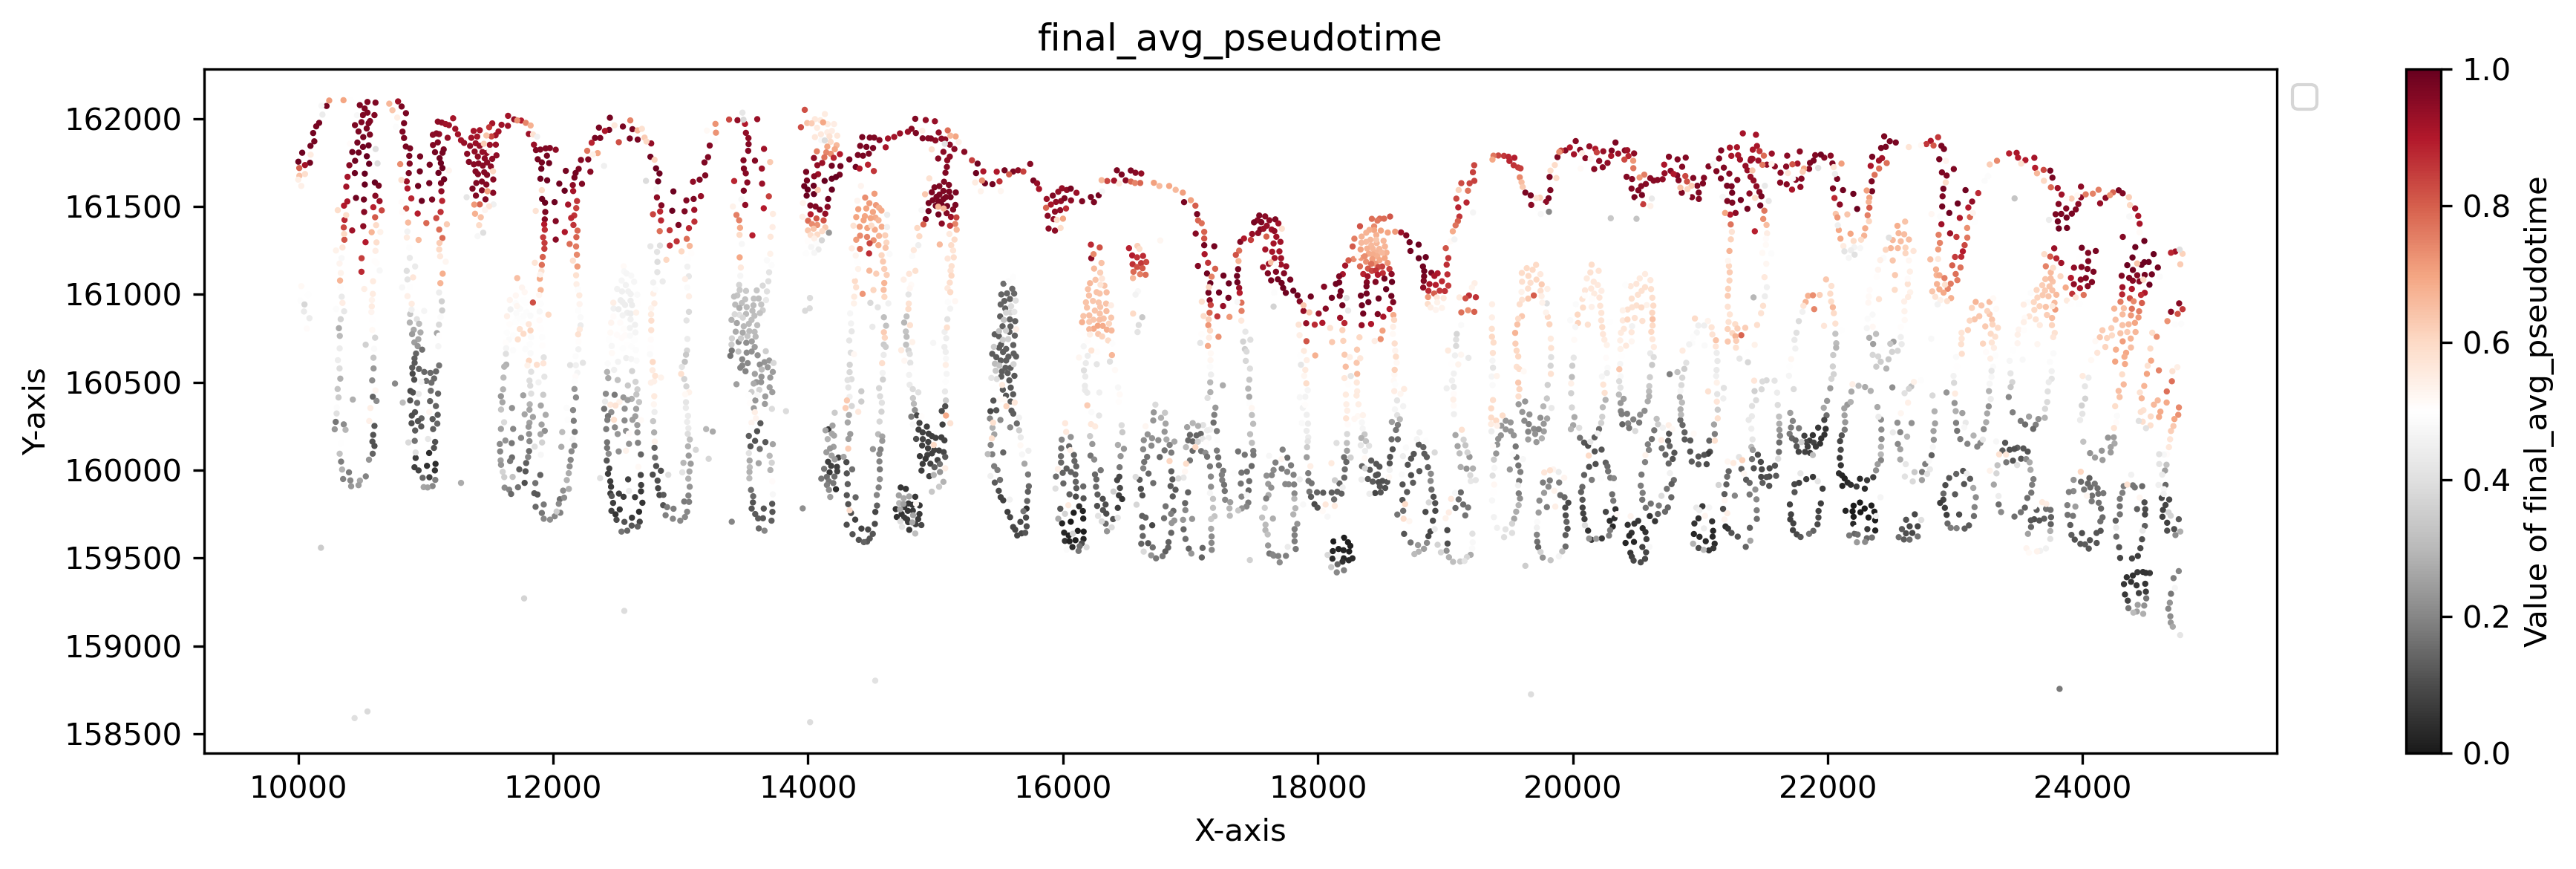

In [27]:
from plastinet.analysis import pseudotime
importlib.reload(pseudotime)

stem_cell_gene_list = ["CD44", "EPHB2", "EPHB3", "SOX9", 'ITGA1', 'ITGB1', 'ITGB2', 'ITGAX', 'ITGB4']
pseudotime.construct_differentiation_path(
    embedding_adata, 
    plastinet.adata, 
    "subset", 
    "epi", 
    stem_cell_gene_list, # starting point gene list
    None,                # ending point gene list
    N=5                 # number of starting cells 
)

plots.plot_continous_obs(embedding_adata, "final_avg_pseudotime", size = 1, figure_size=(15, 4))

In [32]:
adata.obs["final_avg_pseudotime"] = embedding_adata.obs["final_avg_pseudotime"]

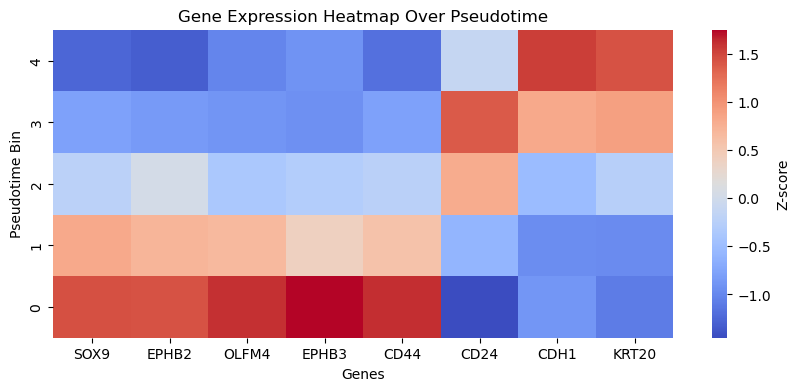

In [65]:
from plastinet.analysis import expression_analysis
importlib.reload(expression_analysis)

validation_genes = ["SOX9", "EPHB2","OLFM4", "EPHB3","CD44", "CD24", "CDH1", "KRT20"]

adata.obs["pseudotime_bins"] = expression_analysis.plot_pseudotime_heatmap(adata, validation_genes, n_bins=5)

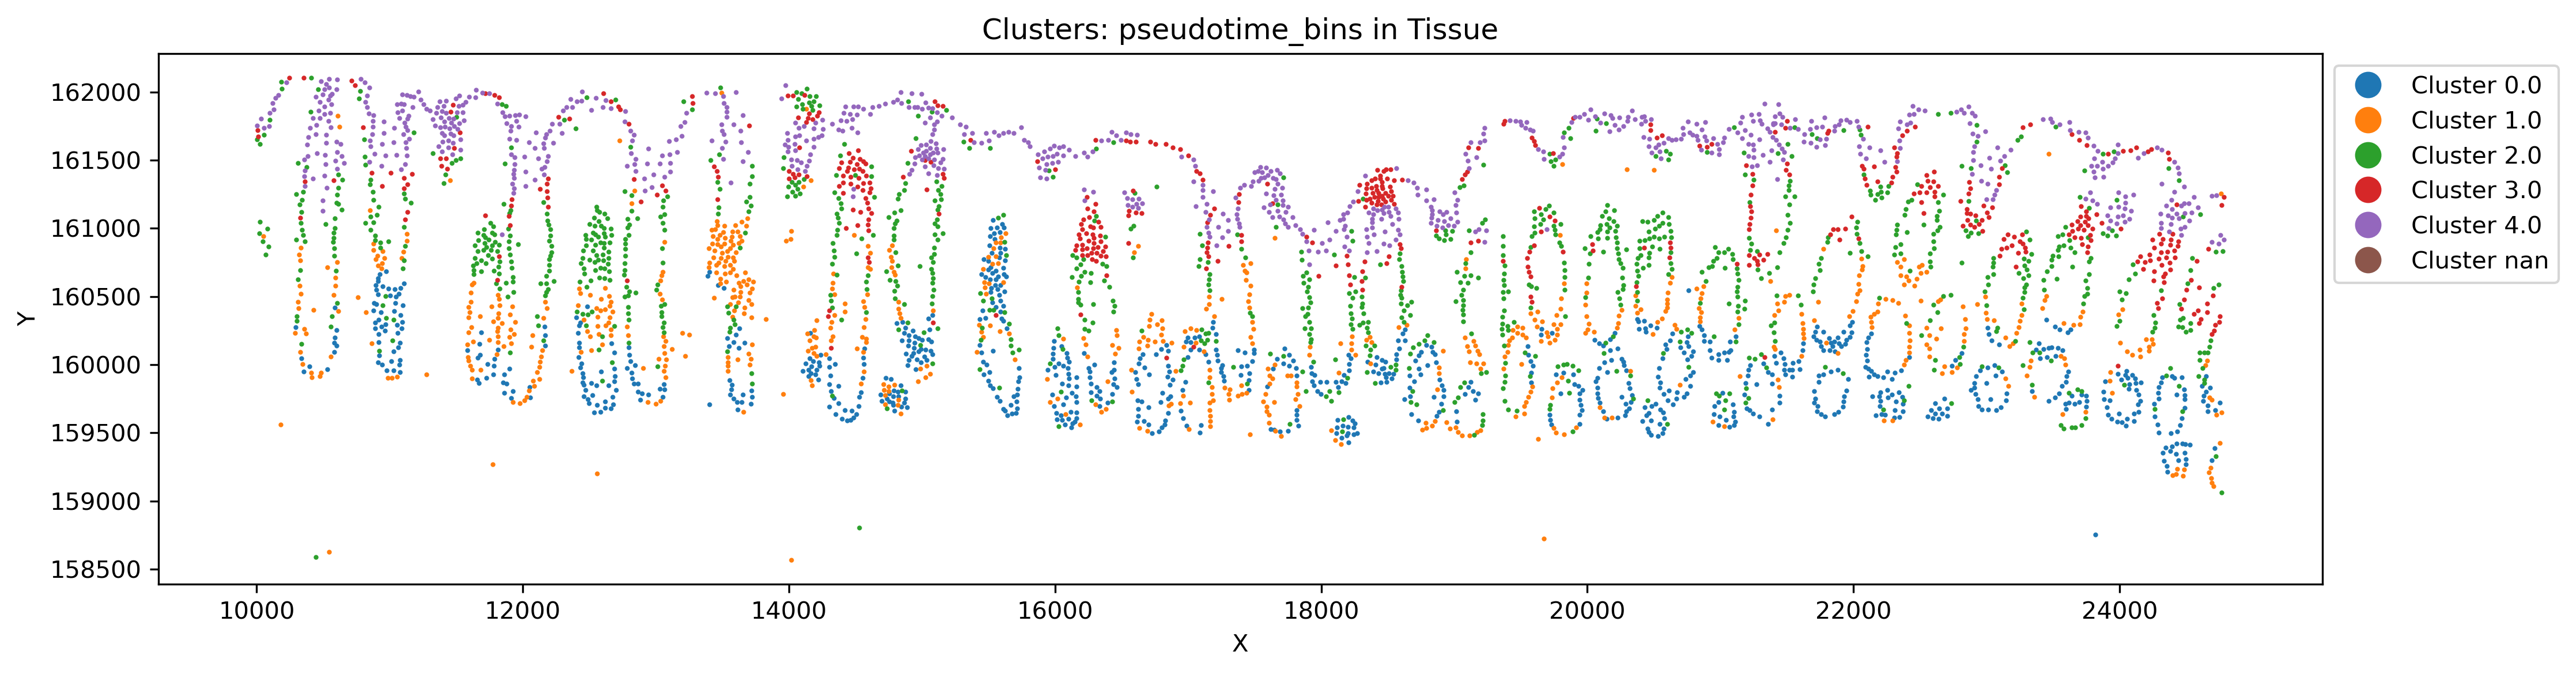

In [66]:
plot_tissue(adata, "pseudotime_bins", tabTen=True, figure_size=(15, 4))

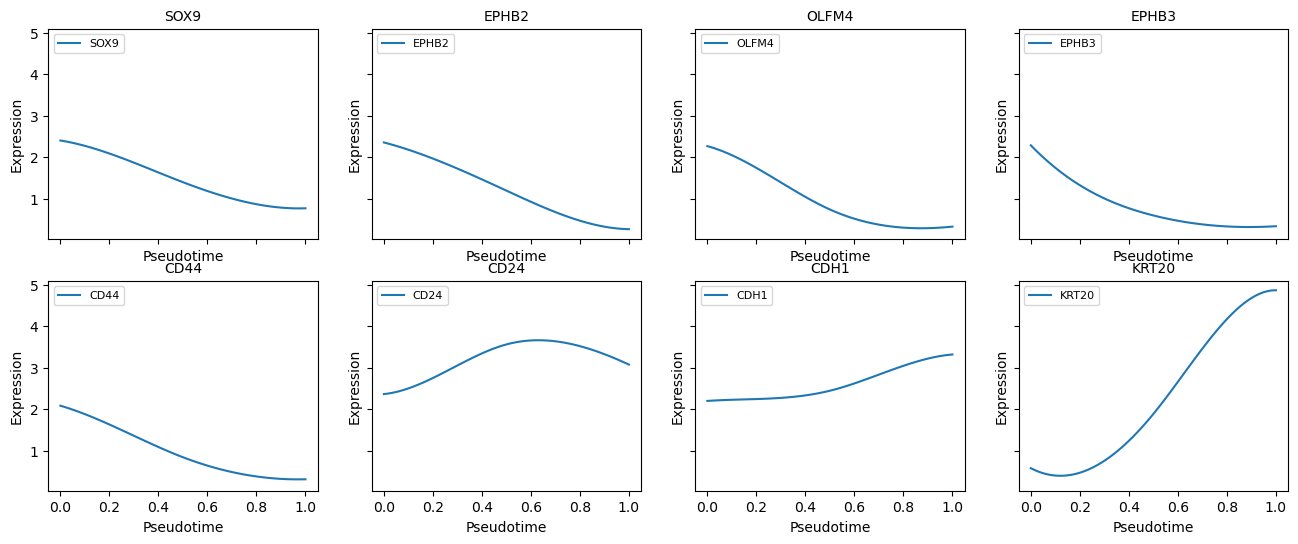

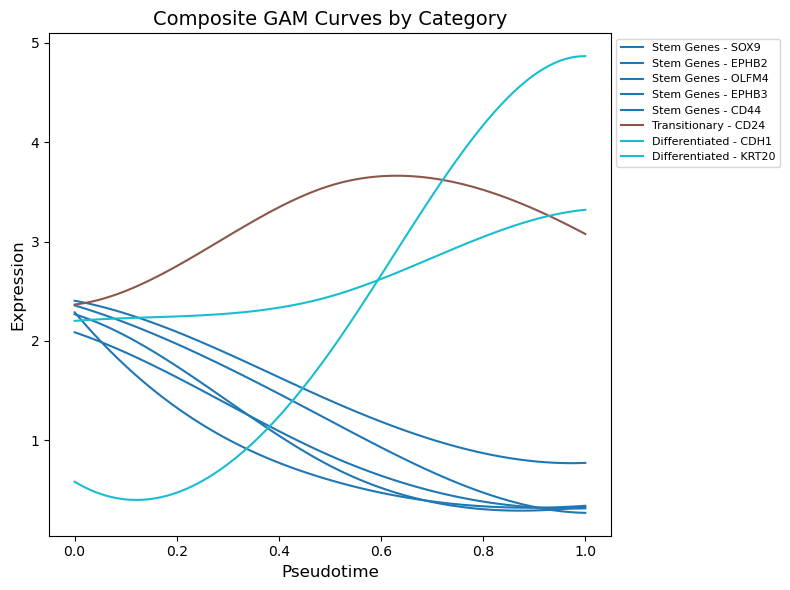

In [75]:
importlib.reload(expression_analysis)


validation_genes = {"Stem Genes" : ["SOX9", "EPHB2","OLFM4", "EPHB3", "CD44"], 
                    "Transitionary":["CD24"], 
                    "Differentiated": ["CDH1", "KRT20"]} 


expression_analysis.plot_gam_curves(adata, validation_genes)

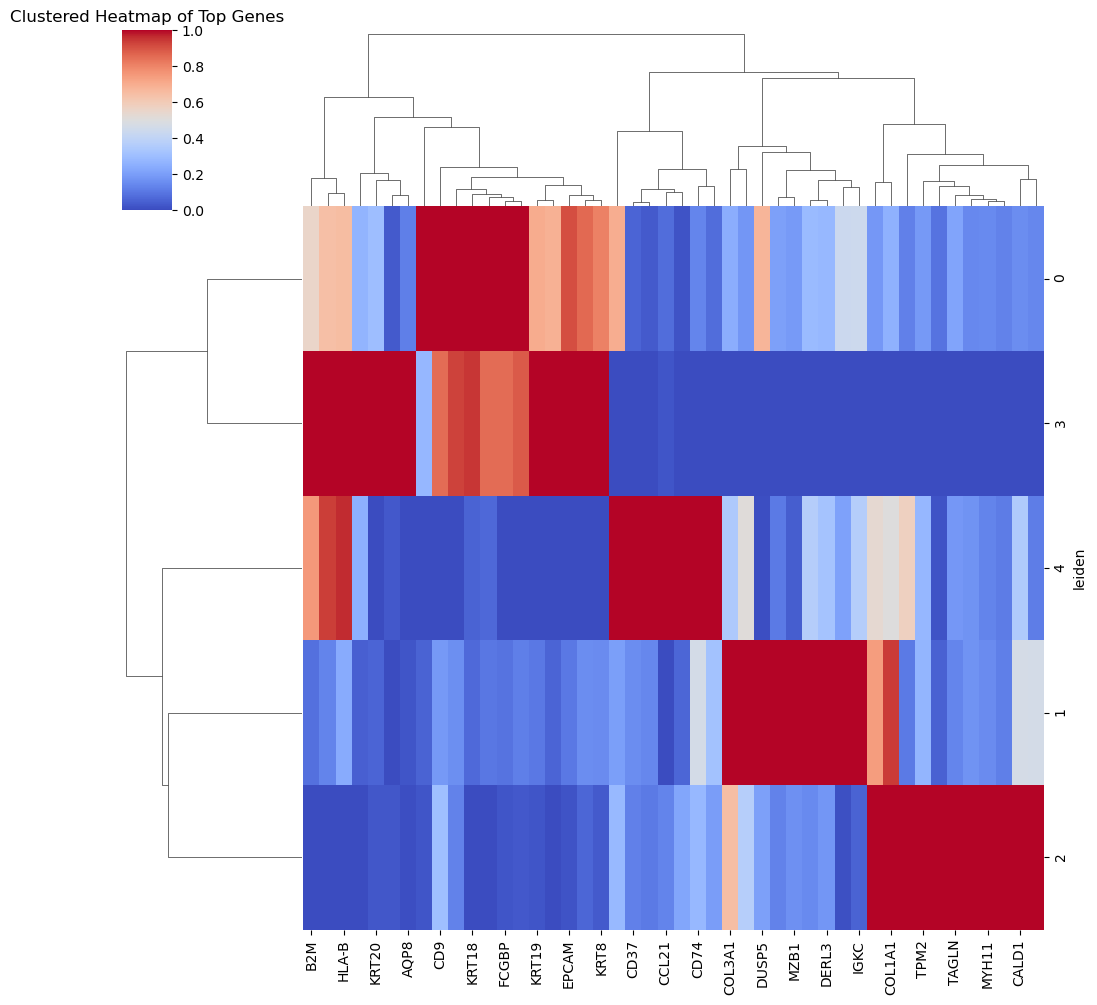

In [93]:
importlib.reload(expression_analysis)

adata.obs["leiden"] = embedding_adata.obs["leiden"]

expression_analysis.plot_top_genes_leiden(adata)

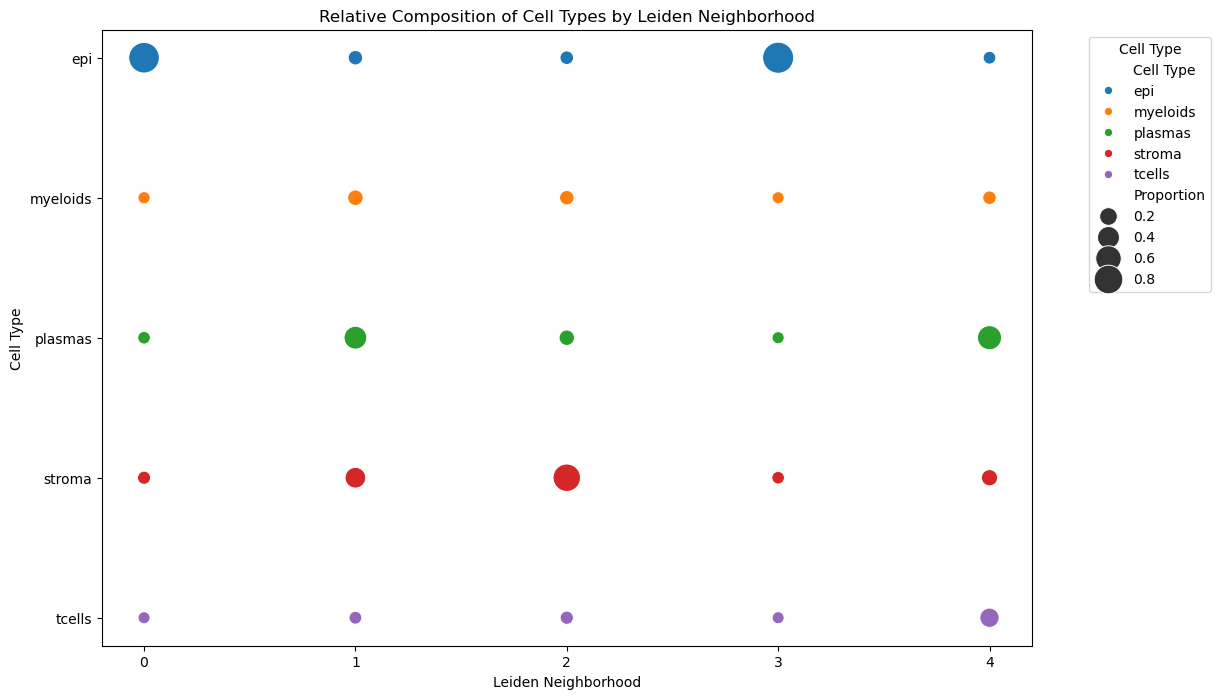

In [104]:
importlib.reload(expression_analysis)

expression_analysis.plot_composition_dotplot(adata, celltype_col='subset')

In [108]:
embedding_adata.obsm['self_attention_weights_layer1']

array([[0.015148762 , 0.015169664 , 0.015146455 , ..., 0.015159346 ,
        0.015178926 , 0.0151556125],
       [0.015155481 , 0.015167539 , 0.015138206 , ..., 0.015171931 ,
        0.0151877785, 0.015141703 ],
       [0.0151507575, 0.015182504 , 0.01514418  , ..., 0.015164586 ,
        0.015173804 , 0.015144855 ],
       ...,
       [0.015143001 , 0.0151592465, 0.015133984 , ..., 0.015150395 ,
        0.0151673565, 0.015147681 ],
       [0.015149577 , 0.0151596   , 0.015148677 , ..., 0.015148311 ,
        0.015166087 , 0.015153958 ],
       [0.015157993 , 0.015162068 , 0.015153606 , ..., 0.015148665 ,
        0.015188722 , 0.015157213 ]], dtype=float32)

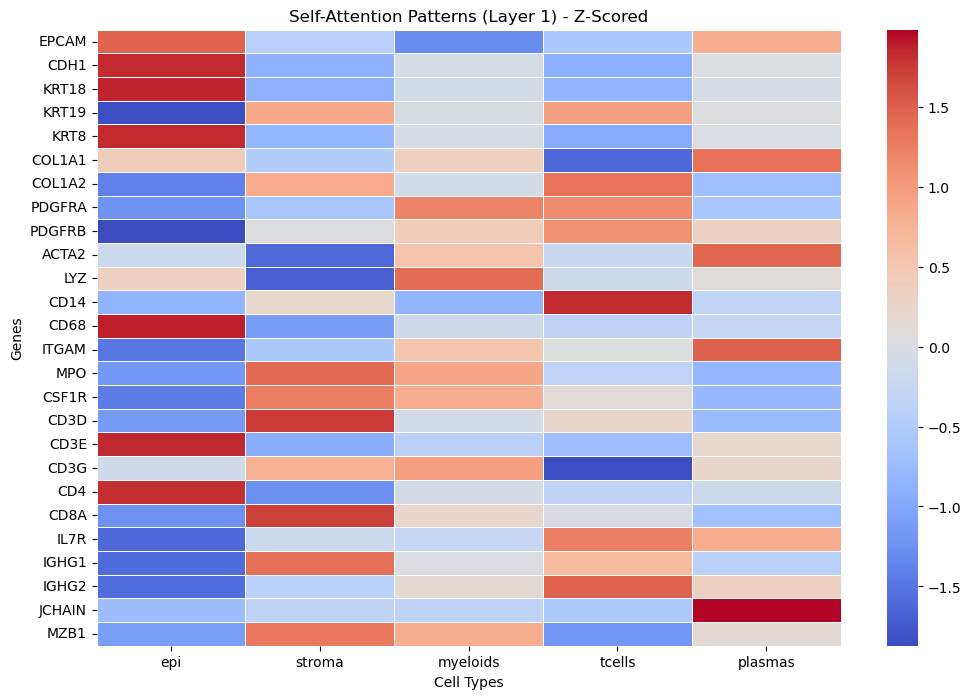

,epi,stroma,myeloids,tcells,plasmas
EPCAM,1.474652,-0.430720,-1.289217,-0.566117,0.810748
CDH1,1.836878,-0.879265,-0.038065,-0.922667,0.003126
KRT18,1.864610,-0.881961,-0.085106,-0.858253,-0.039157
KRT19,-1.830091,0.868873,-0.023117,0.945397,0.038937
KRT8,1.840829,-0.825518,-0.047063,-0.963133,-0.005117
COL1A1,0.394707,-0.485781,0.362085,-1.625471,1.354608
COL1A2,-1.401005,0.848914,-0.088453,1.344608,-0.707626
PDGFRA,-1.210262,-0.594597,1.226648,1.158761,-0.578210
PDGFRB,-1.870172,0.010891,0.424756,1.100010,0.334515
ACTA2,-0.160035,-1.599689,0.537878,-0.218471,1.441646


In [129]:
from plastinet.analysis import attention_analysis
importlib.reload(attention_analysis)


marker_genes = ["EPCAM", "CDH1", "KRT18", "KRT19", "KRT8",
               "COL1A1", "COL1A2", "PDGFRA", "PDGFRB", "ACTA2", "FAP",
                "LYZ", "CD14", "CD68", "ITGAM", "MPO", "CSF1R",
                "CD3D", "CD3E", "CD3G", "CD4", "CD8A", "IL7R", "TRAC", 
                "CD138", "IGHG1", "IGHG2", "IGHG3", "IGHG4", "JCHAIN", "PRDM1", "MZB1"
               ]

attention_analysis.analyze_self_attention_layer1(embedding_adata, adata, gene_list = marker_genes, normalize=True)